In [1]:
pip install deepxde


     |████████████████████████████████| 92kB 10.9MB/s 
     |████████████████████████████████| 102kB 13.9MB/s 


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import io
import re

import matplotlib.pyplot as plt
import numpy as np
import requests

import deepxde as dde
from deepxde.backend import tf


Deepxde backend not selected or invalid.  Assuming tensorflow.compat.v1 for now.
Using backend: tensorflow.compat.v1


Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDEBACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow (all lowercase)
Instructions for updating:
non-resource variables are not supported in the long term


Compiling model...
Building feed-forward neural network...
'build' took 0.077541 s



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 5.584493 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.55e-03, 5.23e-02, 3.08e-01]    [2.55e-03, 0.00e+00, 0.00e+00]    []  
1000      [5.15e-04, 7.36e-05, 8.69e-05]    [5.15e-04, 0.00e+00, 0.00e+00]    []  
2000      [1.60e-04, 1.15e-05, 1.14e-05]    [1.60e-04, 0.00e+00, 0.00e+00]    []  
3000      [7.81e-05, 7.29e-06, 1.70e-06]    [7.81e-05, 0.00e+00, 0.00e+00]    []  
4000      [5.05e-05, 6.63e-06, 1.94e-06]    [5.05e-05, 0.00e+00, 0.00e+00]    []  
5000      [2.27e-05, 5.26e-06, 5.48e-07]    [2.27e-05, 0.00e+00, 0.00e+00]    []  
6000      [1.58e-05, 6.55e-06, 3.27e-06]    [1.58e-05, 0.00e+00, 0.00e+00]    []  
7000      [1.15e-04, 2.81e-05, 9.75e-05]    [1.15e-04, 0.00e+00, 0.00e+00]    []  
8000      [1.11e-05, 2.77e-06, 1.93e-06]    [1.11e-05, 0.00e+00, 0.00e+00]    []  
9000      [9.57e-06, 2.50e-06, 8.01e-07]    [9.57e-06, 0.00e+00, 0.00e+00]    []  
10000   

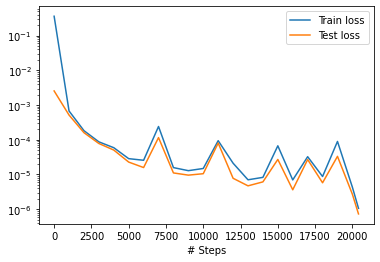

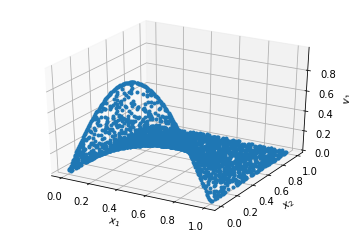

Mean residual: 0.00053664664
L2 relative error: 1.2295102042287467


In [3]:
def heat_eq_exact_solution(t, x): #Sinusoidal initial conditions
    return np.exp(-(n**2*np.pi**2*a*t)/(L**2))*np.sin(n*np.pi*x/L)

def gen_exact_solution():

    # Number of points in each dimension
    x_dim, t_dim = (256, 201)

    # Bounds of 'x' and 't'
    x_min, t_min = (0, 0.)
    x_max, t_max = (L, 1.)

    # Create tensors 
    t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
    x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
    usol = np.zeros((x_dim, t_dim)).reshape(x_dim, t_dim)

    # Obtain the value of the exact solution for each generated point
    for i in range(x_dim):
        for j in range(t_dim):
            usol[i][j] = heat_eq_exact_solution(x[i],t[j])

    # Save solution
    np.savez('heat_eq_data', t=t, x=x, usol=usol)
    data = np.load('heat_eq_data.npz')


def gen_testdata():
    data = np.load('heat_eq_data.npz')
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

def main():

    def pde(x, y):
        dy_t = dde.grad.jacobian(y, x, i=0, j=1)
        dy_xx = dde.grad.hessian(y, x, i=0, j=0)
        return dy_t - a*dy_xx

    geom = dde.geometry.Interval(0, L)
    timedomain = dde.geometry.TimeDomain(0, 1)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)

    bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
    ic = dde.IC(
        geomtime, lambda x: np.sin(n*np.pi*x[:, 0:1]/L), lambda _, on_initial: on_initial
        )

    data = dde.data.TimePDE(
        geomtime, pde, [bc, ic], num_domain=2540, num_boundary=80, num_initial=160
    )
    net = dde.maps.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
    model = dde.Model(data, net)

    model.compile("adam", lr=1e-3)
    model.train(epochs=20000)
    model.compile("L-BFGS-B")
    losshistory, train_state = model.train()
    dde.saveplot(losshistory, train_state, issave=True, isplot=True)

    X, y_true = gen_testdata()
    y_pred = model.predict(X)
    f = model.predict(X, operator=pde)
    print("Mean residual:", np.mean(np.absolute(f)))
    print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
    np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))


if __name__ == "__main__":

    # Problem parameters
    a = 0.4 # Thermal diffusivity
    L = 1 # Lenght of the rod
    n = 1 # Frequency of the sinusoidal initial conditions

    # Generate a exact solution
    gen_exact_solution()

    # Solve
    main()
